<a href="https://colab.research.google.com/github/JayNguyen-123/EMAIL_CLASSIFICATION/blob/main/Pytorch_Email_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('/content/emails.csv')
df.head()


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [4]:
print(f"Duplicate value in this data: {df.duplicated().sum()}")
print("Delete duplicate rows")
df.drop_duplicates(inplace=True)
print(f"All duplicates removed! {df.shape}")


Duplicate value in this data: 33
Delete duplicate rows
All duplicates removed! (5695, 2)


In [5]:
df['spam'].value_counts()


,count
spam,
0,4327
1,1368


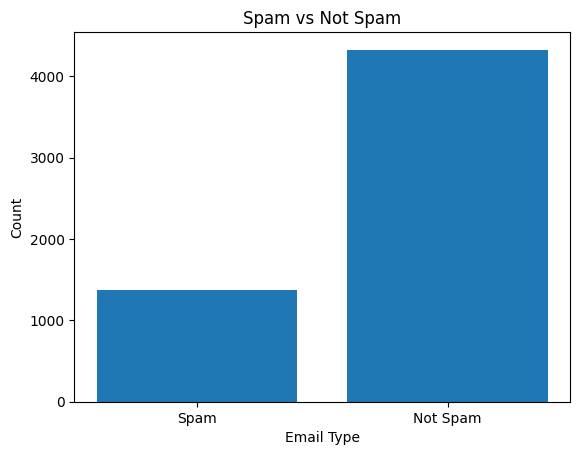

In [6]:
# Visualize data
spam_count = df['spam'].value_counts()[1]
not_spam_count = df['spam'].value_counts()[0]

plt.bar(['Spam', 'Not Spam'], [spam_count, not_spam_count])
plt.title("Spam vs Not Spam")
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.show()


In [7]:
# Text preprocessing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
random_sample = df['text'].sample(2)
for text in random_sample:
  print(text, '\n')


Subject: visit to wharton , december 6  i would like to invite you to join mewhen i visit to the wharton risk  management and decision processes center on  december 6 . the meeting will take place in the morning , 9 : 00 - 12 : 00 ,  followed by lunch .  the description of the center is at the bottom of the message . the web site  address is  the objective of the trip is to discuss joint research projects in the area  of risk management and alternative risk  transfer .  please , feel free to contact me with recommendations regarding discussion  and potential research topics .  the best hotel to stay in is the inn at penn .  http : / / www . innatpenn . com / contact . html  the inn at penn  sansom common , 3600 sansom street  philadelphia , pa . 19104  phone : 1 - 800 - 809 - 7001  fax : 215 - 222 - 4600  vince kaminski  the mission of the wharton risk management  and decision processes center is to carry  out a program of basic and applied research  to promote effective policies and p

In [11]:
def preprocessing_text(text):
  text = text.lower()
  tokens = word_tokenize(text)
  # remove punctuation and non-alphanumeric characters
  tokens = [word for word in tokens if word.isalnum()]

  # remove stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]

  # initialize stemming
  stemmer = PorterStemmer()
  tokens = [stemmer.stem(word) for word in tokens]

  # join tokens back into processed text
  processed_text = ' '.join(tokens)

  return processed_text



In [12]:
# Assign a new column with processed text
df['processed_text'] = df['text'].apply(preprocessing_text)
df['processed_text'].sample(3)


,processed_text
5583,subject park 777 clay hi loui sever employe lo...
3067,subject messag ken rice dorothi problem pleas ...
2644,subject oper risk michael scienc measur oper r...


In [13]:
# split data(train & test) and Vectorize the text data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X_test = df['processed_text']
y_labels = df['spam']
X_train, X_test, y_train, y_test = train_test_split(X_test, y_labels, test_size=0.3, random_state=42)


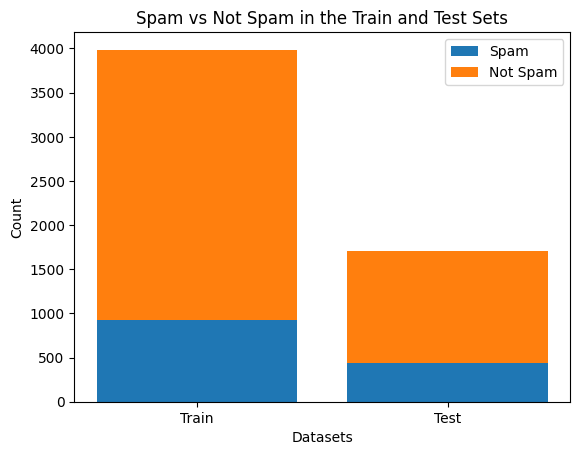

In [14]:
# visualize numbers of spam and non-spam emails in the train and test sets
spam_counts = [y_train.value_counts()[1], y_test.value_counts()[1]]
non_spam_counts = [y_train.value_counts()[0], y_test.value_counts()[0]]

x_labels = ['Train', 'Test']

plt.bar(x_labels, spam_counts, label='Spam')
plt.bar(x_labels, non_spam_counts, bottom=spam_counts, label='Not Spam')
plt.title("Spam vs Not Spam in the Train and Test Sets")
plt.xlabel('Datasets')
plt.ylabel('Count')
plt.legend()
plt.show()


In [15]:
# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"X_train_vec: {X_train_vec.toarray().shape}")
print(f"X_test_vec: {X_test_vec.toarray().shape}")


X_train_vec: (3986, 24812)
X_test_vec: (1709, 24812)


In [16]:
# convert vectorized data and labels into pytorch tensor
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [17]:
X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32, device=device)

X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32, device=device)


In [18]:
# create tensor datasets and data loaders
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [19]:
# Build a simple feedforward neural network model
from torch import nn

class SpamFilter(nn.Module):
  def __init__(self, input_size):
    super(SpamFilter, self).__init__()
    self.layer1 = nn.Linear(in_features=input_size, out_features=128)
    self.layer2 = nn.Linear(in_features=128, out_features=64)
    self.layer3 = nn.Linear(in_features=64, out_features=1)

  def forward(self, x):
    out = torch.relu(self.layer1(x))
    out = torch.relu(self.layer2(out))
    out = torch.sigmoid(self.layer3(out))
    return out


In [20]:
# initialize the model
input_size = X_train_vec.shape[1]
model0 = SpamFilter(input_size).to(device)


In [21]:
# loss function
criterion = nn.BCELoss()

# optimizer
optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.001)


In [22]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
  # set the model to training mode
  model0.train()
  running_loss = 0.0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model0(inputs)

    loss = criterion(outputs, labels.unsqueeze(1))
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}")


Epoch 1/10, Loss: 12.738771744072437
Epoch 2/10, Loss: 0.965555940871127
Epoch 3/10, Loss: 2.221015685296152
Epoch 4/10, Loss: 0.18186642932414543
Epoch 5/10, Loss: 0.07764534268062562
Epoch 6/10, Loss: 0.04896579261912848
Epoch 7/10, Loss: 0.03315419658974861
Epoch 8/10, Loss: 0.023964978980075102
Epoch 9/10, Loss: 0.01746952541657265
Epoch 10/10, Loss: 0.013344921614589111


In [23]:
# Evaluation
model0.eval()

correct = 0
total = 0

with torch.inference_mode():
  for inputs, labels in test_loader:
    outputs = model0(inputs)
    predicted = (outputs > 0.5).float()

    total += labels.size(0)
    correct += (predicted == labels.unsqueeze(dim=1)).sum().item()

accuracy = correct/total
print('Test Accuracy: {:.2f}%'.format(100 * accuracy))



Test Accuracy: 98.95%


In [24]:
spam_email = """Subject: Urgent: Claim Your Prize Now!

Congratulations! You have been selected as the lucky winner of our grand prize giveaway! Claim your prize now by clicking on the link below. Don't miss out on this amazing opportunity!

Click here to claim your prize: superlottery@gmail.com

Hurry, this offer is only available for a limited time!

Best Regards,
Spammy Marketing Team
"""
non_spam_email = """Subject: Meeting Agenda for Tomorrow

Hi Team,

I hope this email finds you well. I wanted to remind everyone about the meeting scheduled for tomorrow at 10:00 AM. Below is the agenda:

1. Review of project milestones
2. Discussion on upcoming deadlines
3. Any other business

Please come prepared with any updates or questions you may have. Looking forward to a productive meeting.

Best regards,
Mr. Bannerjee
"""

def classify_email(email_text):
  # preprocess the email
  preprocessed_email = preprocessing_text(email_text)

  # vectorize the preprocessed email
  vectorized_email = vectorizer.transform([preprocessed_email])

  # convert the vectorized email into Pytorch tensor
  email_tensor = torch.tensor(vectorized_email.toarray(), dtype=torch.float32, device=device)

  # Use the model for inference
  output = model0(email_tensor)

  # if the email is spam or not
  if output > 0.5:
    return "spam"
  else:
    return "not spam"



In [25]:
# List of emails
email_examples = [spam_email, non_spam_email]
for i, email_text in enumerate(email_examples, start=1):
  classification = classify_email(email_text)
  print(f"Email {i} is classified as {classification}")


Email 1 is classified as spam
Email 2 is classified as not spam


In [26]:
# Saving the model
from pathlib import Path

# Create model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save path
MODEL_NAME = "Spam_Classification.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# save the model's state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model0.state_dict(), f=MODEL_SAVE_PATH)


Saving model to models/Spam_Classification.pth
